In [1]:
import pytesseract
import pandas as pd
from PIL import Image, ImageFilter, ImageEnhance
from pdf2image import convert_from_path
import os

TESSERACT_OCR_PATH = os.getenv('TESSERACT_OCR_PATH')
POPPLER_PATH = os.getenv('POPPLER_PATH')

def preprocess_image(image: Image):
    # Convert to grayscale
    image = image.convert('L')
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)
    # Apply sharpening
    image = image.filter(ImageFilter.SHARPEN)
    return image

def find_word(data, word, conf_threshold=10):
    filtered_data = data[data.conf >= conf_threshold]
    word_loc = filtered_data[filtered_data['text'].str.contains(word, case=False)]
    return word_loc

def filter_table_area(data:pd.DataFrame, start_word:str, stop_word:str, conf_threshold=0):
    start_word_loc = find_word(data, start_word, conf_threshold)
    stop_word_loc = find_word(data, stop_word, conf_threshold)
    filtered_data = data[(data.top >= start_word_loc.top.values[0])&(data.top < min(stop_word_loc.top.values))]
    return filtered_data

def extract_column(data, name, conf_threshold, offset=0, width=0):
    word_loc = find_word(data, name, conf_threshold)
    column = data[(data.conf > conf_threshold) & (data.left >= word_loc.left.values[0]+offset) & (data.left < word_loc.left.values[0]+width)& (data.top >= word_loc.top.values[0])]
    return column

def join_words_in_line(data, line_num):
    desc = ''
    for text in data[data.line_num == line_num].text:
        if desc == '':
            desc = text
        else:
            desc = " ".join([desc, text])
    return desc

def data_validation(data, regex):
    validated_data = data[data['text'].str.contains(regex)]
    return validated_data

In [2]:
dpi = 600
ch_width = int(dpi*1.2/25.4)

images = convert_from_path(r"test_data\3000269816-IVC(05282024).PDF", dpi=dpi, poppler_path=POPPLER_PATH)

In [3]:
all_processed_image_data = []

for image in images:
    image_processed = preprocess_image(image)
    # image_processed = image
    processed_image_data = pytesseract.image_to_data(image_processed,lang='SNG', config=f'--dpi {dpi}', output_type=pytesseract.Output.DATAFRAME)
    all_processed_image_data.append(processed_image_data)

In [4]:
column_list = ['line no', 'packed by', 'qty ordered', 'qty shipped', 'item number', 'description', 'price', 'extended price', 'discounted amount']

extracted_table = pd.DataFrame(columns=column_list)

In [5]:
extracted_table

Empty DataFrame
Columns: [line no, packed by, qty ordered, qty shipped, item number, description, price, extended price, discounted amount]
Index: []

In [6]:
table_data = filter_table_area(all_processed_image_data[0], 'packed', 'returns')

In [7]:
packed_by = extract_column(table_data, 'packed', 0, 0, 6*ch_width)

In [8]:
find_word(table_data, 'ordered', conf_threshold=50)

level  page_num  block_num  par_num  line_num  word_num  left   top  \
185      5         1         19        1        11         3   590  1485   

     width  height       conf     text  
185    194      40  89.460815  ORDERED

In [9]:
qty_ordered = extract_column(table_data, 'ordered', 0, -4*ch_width, 7*ch_width)

In [10]:
extract_column(table_data, 'shipped', 0, -1*ch_width, 2*ch_width)

level  page_num  block_num  par_num  line_num  word_num  left   top  \
187      5         1         19        1        11         5  1071  1485   
205      5         1         19        1        13         3  1069  1645   
224      5         1         19        1        16         3  1069  1964   
247      5         1         19        1        19         3  1069  2283   
270      5         1         19        1        22         3  1069  2602   
287      5         1         19        1        24         3  1056  2775   
294      5         1         19        1        25         3  1078  2921   
316      5         1         19        1        28         3  1078  3240   
338      5         1         19        1        31         3  1078  3560   
355      5         1         19        1        33         3  1056  3732   
360      5         1         19        1        34         3  1069  3879   
380      5         1         19        1        37         3  1078  4198   
395      5         1         19        1        39         3  1081  4375   
401      5         1         19        1        40         3  1090  4517   
422      5         1         19        1        43         3  1078  4836   
436      5         1         19        1        45         3  1056  5009   
442      5         1         19        1        46         3  1090  5155   
459      5         1         19        1        49         3  1090  5475   
476      5         1         19        1        52         3  1090  5794   

     width  height       conf                 text  
187    176      40  92.241066              SHIPPED  
205     74      57  93.046516                   80  
224     74      57  88.713303                   40  
247     74      57  89.803696                   40  
270     74      57  92.868126                   20  
287   3708      85   5.395775       __________®-5s  
294     56      57   7.544907                    M  
316     56      57  90.666443                   10  
338     56      57  90.130371                   10  
355   3708      85   2.214035  ________________2-5  
360     74      57  92.962654                   20  
380     56      57  82.640846                   10  
395    169      81  41.746162                   -o  
401     32      57  87.104759                    8  
422     56      57  72.994263                    2  
436   3708      85   8.384674      ___________®-4«  
442     32      57  86.240608                    2  
459     32      57  87.104759                    8  
476     32      57  87.104759                    8

: 

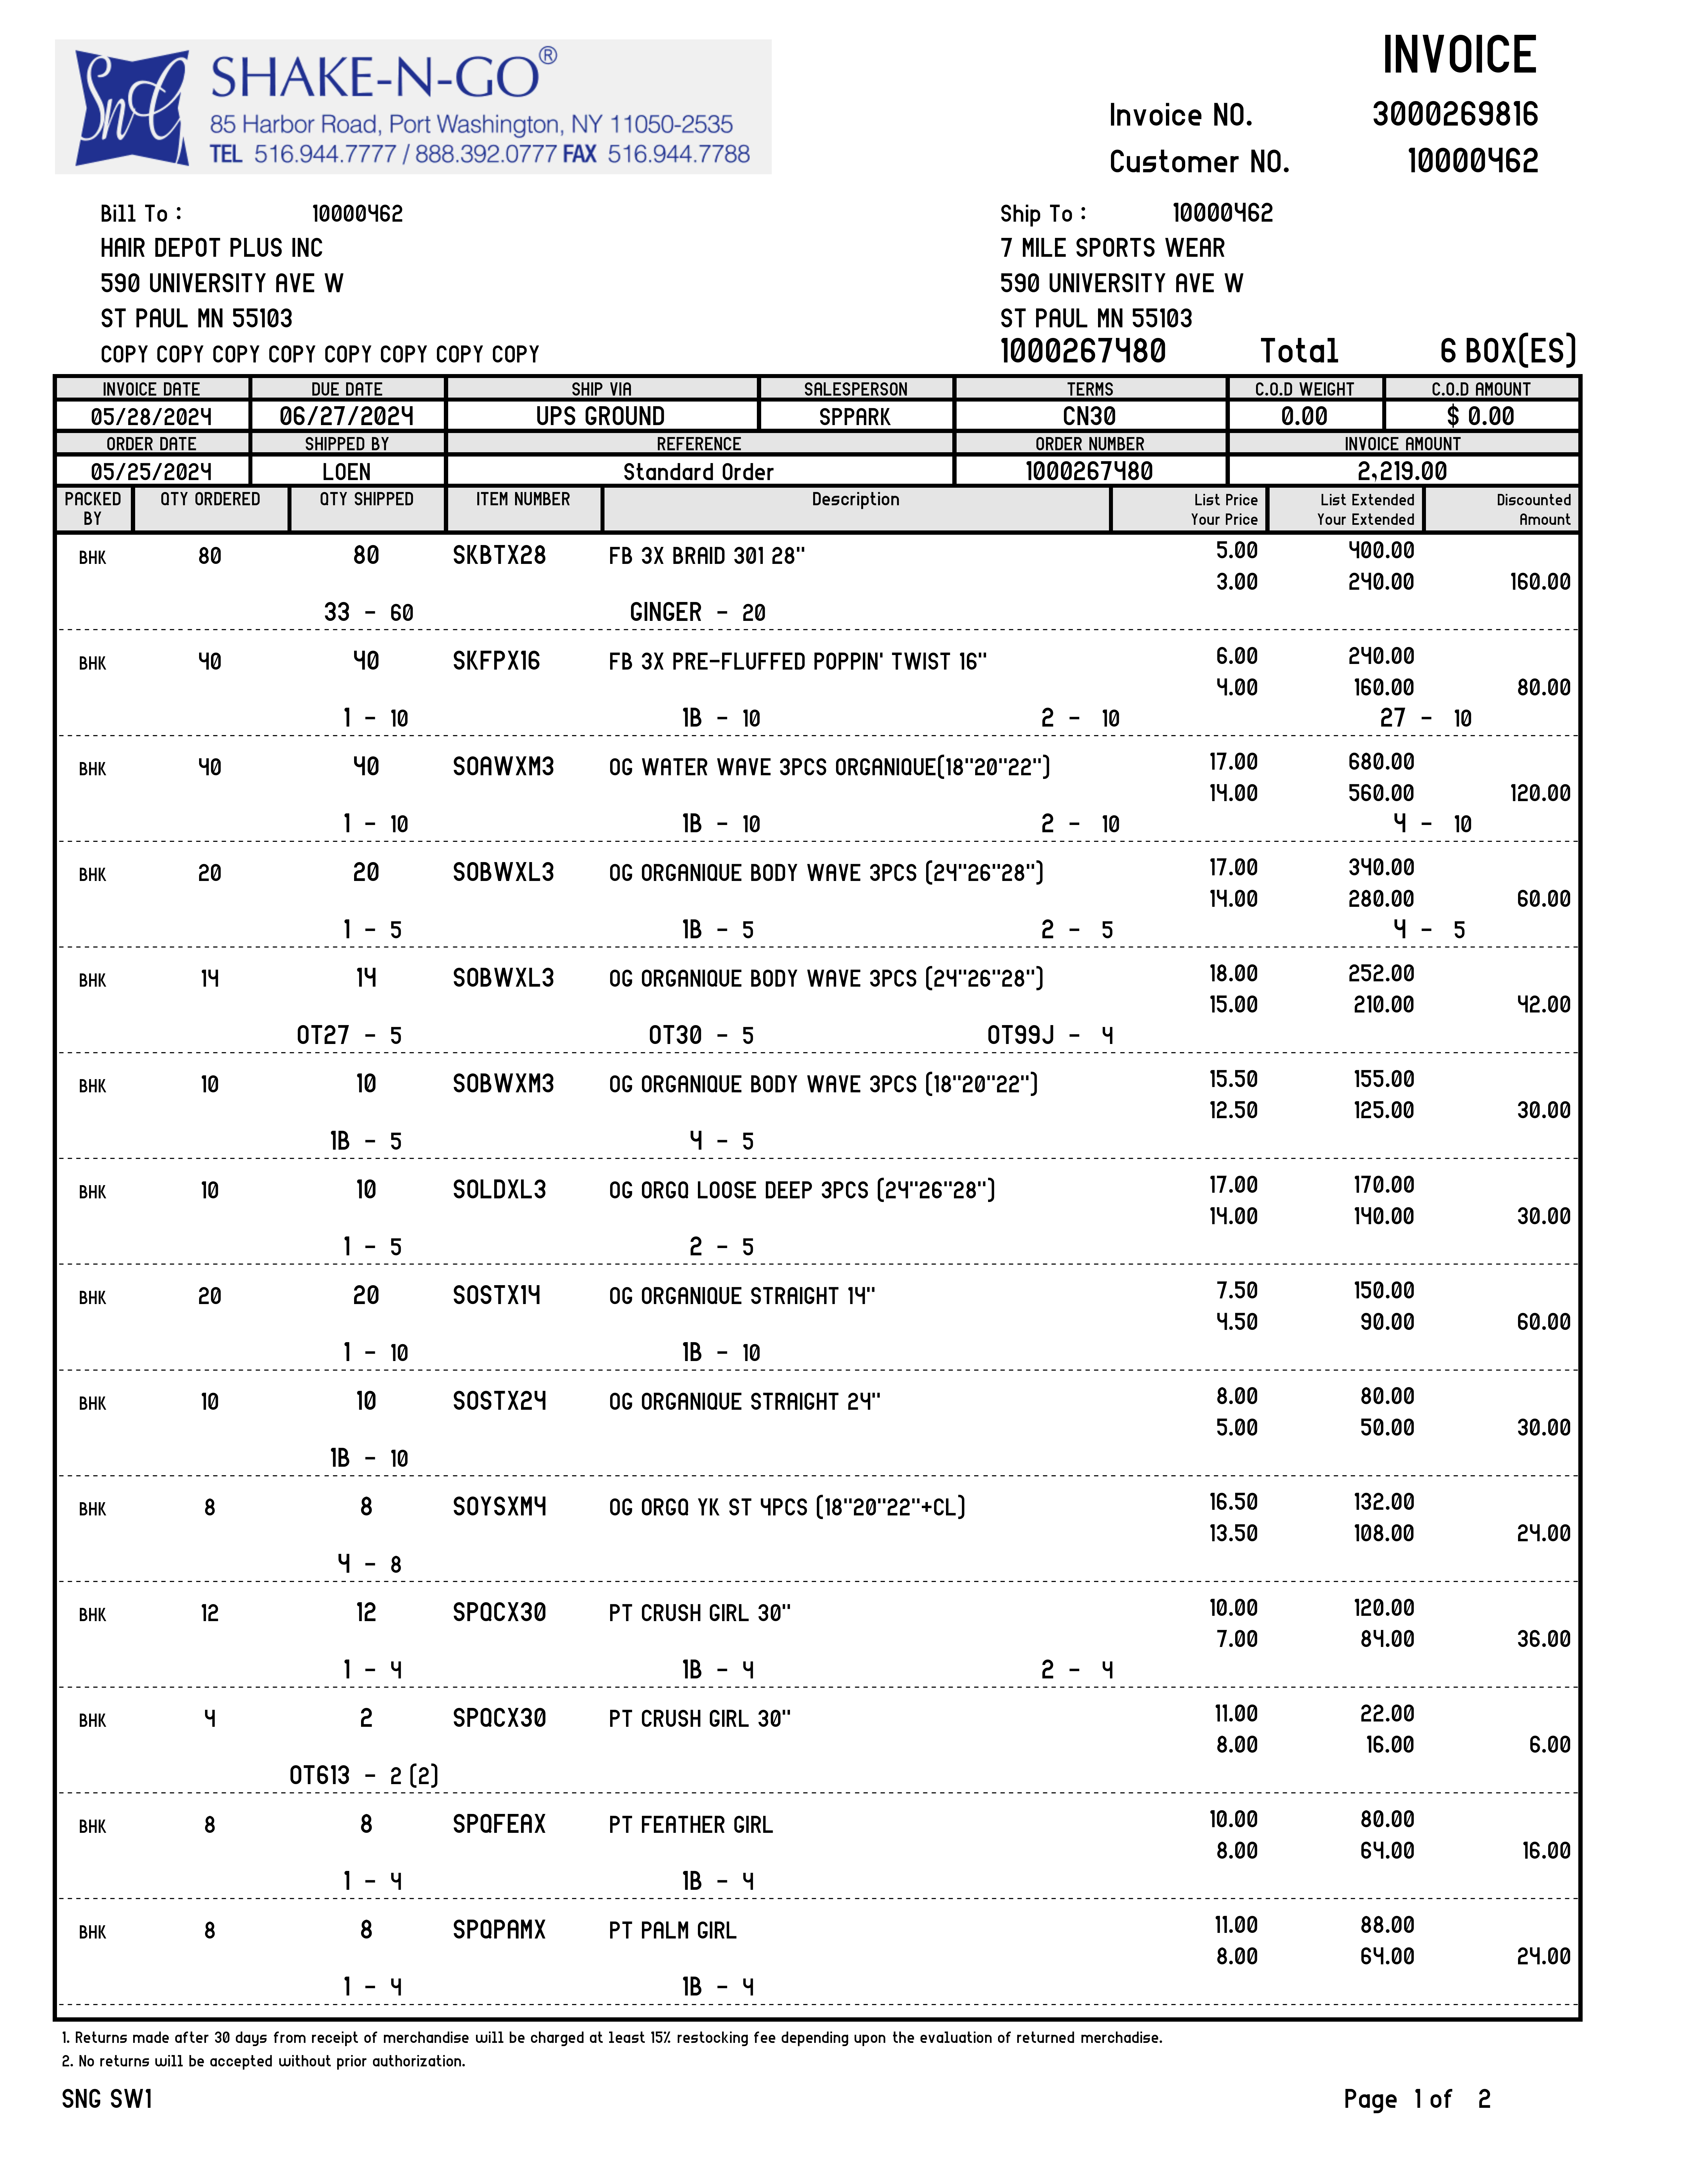

In [28]:
images[0]

In [17]:
temp = all_processed_image_data[0]